# Imagery and Areas of Interest

Areas of Interest (AOIs) are a critical part of imagery analysis for a number of reasons. First, they help define regions within large strips of imagery that are small enough to access efficently, and can be used to focus an analysis on specific subsets or features within an image. Second AOIs provide a means for iterating over large areas via spatial windows. This makes it possible to process entire images, or very large AOIs, in more scalable ways such as processing in parallel. 

In this notebook we'l take a look at a few ways to define AOIs and use them to subset images in a variety of ways. We'll begin simple and move into more advanced strategies for slicing images into peices in order to process data in chunks.

We'll start by creating a `CatalogImage` instance for an entire Worldview2 strip and printing its "shape". The shape refers to the number bands and pixels (rows and columns) in the image. The shape tells us the overall size of the image in pixels. Since data are stored on the server as tiles (typically 256x256 tiles) we cna get a sense of the number of tiles in image by dividing the rows/cols by 256. 

In [1]:
from gbdxtools import CatalogImage

catalog_id = '104001001F995D00'
image = CatalogImage(catalog_id)
print image.shape

rows = image.shape[1]
cols = image.shape[-2]
print ((rows/256) * (cols/256)), 'tiles'

(8, 87323, 14471)
116281 tiles


### Defining AOIs

Now that we've got an image we can explore different ways to create an AOI and select the pixels in our image that match the extent of the AOI. We'll use some features of `shapely` to convert a bounding box into a few different forms and ensure that the shape of each resulting AOI matches the others.

In [2]:
from shapely.geometry import box

# Basic AOI
bbox = [-74.02008533477785, 40.699641625343126, -74.00184631347658, 40.71145106322093]
aoi_bbox = image.aoi(bbox=bbox)

print 'BBOX shape', aoi_bbox.shape


# WKT
wkt = box(*bbox).wkt
aoi_wkt = image.aoi(wkt=wkt)

print 'WKT', aoi_wkt.shape
assert aoi_wkt.shape == aoi_bbox.shape


# Geojson
geojson = box(*bbox).__geo_interface__
aoi_geojson = image.aoi(geojson=geojson)

print 'GeoJSON Shape', aoi_geojson.shape
assert aoi_geojson.shape == aoi_bbox.shape

BBOX shape (8, 998, 1542)
WKT (8, 998, 1542)
GeoJSON Shape (8, 998, 1542)


Fetching Image... 28 tiles


Fetching Image... 28 tiles


Fetching Image... 28 tiles


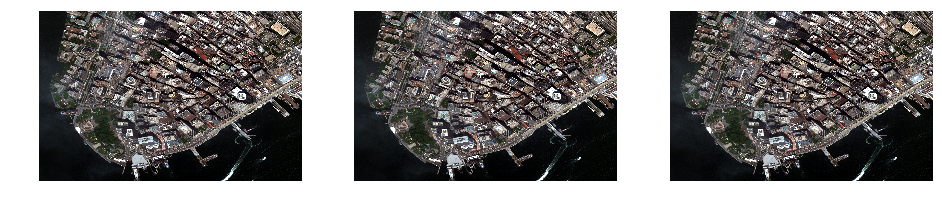

In [3]:
# Look at each AOI
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))

imgs = [aoi_bbox, aoi_wkt, aoi_geojson]

for i in xrange(3):
    plt.subplot(1, 3, i+1)
    plt.axis('off')
    plt.imshow(imgs[i].rgb())
    
plt.show()

### Array Slicing

Images are essentially Numpy arrays, and each image has a "shape" that follows `bands`, `rows`, `cols`. We can slice and dice our images following <a href="https://docs.scipy.org/doc/numpy/reference/arrays.indexing.html" target="_blank">standard Numpy slicing/indexing patterns.</a> Below we'll show how to extract a random area of the image we created above using pixel coordinates.

Fetching Image... 36 tiles


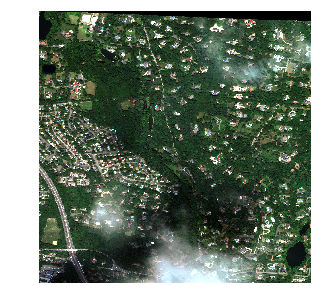

Fetching Image... 25 tiles


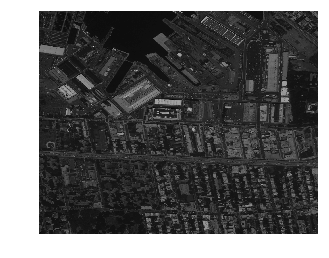

In [4]:
# All bands for the upper left corner 
aoi = image[:, 0:1500, 0:1500]
aoi.plot(w=5, h=5)

# A single band for a random pixel location
aoi = image[[4], ..., 26500:27500, 10500:11750]
aoi.plot(w=5, h=5)

### The Image GeoInterface

Every image class comes defined with a `__geo_interface__` that is used for interoperably with the `shapely` python library. This let's us treat images like shapely objects and perform spatial operations like `contains`, `intersects`, or `within` on images. This is really helpful comparing images to things like GeoJSON features or comparing images to each other. 

In [5]:
from shapely.geometry import shape

aoi_shp = shape(aoi)
img_shp = shape(image)

assert img_shp.contains(aoi_shp)
assert aoi_shp in image
assert aoi_shp.within(img_shp)
assert not aoi_shp.crosses(img_shp)

### Indexing Imagery with other images

We can leverage the geo_interface and shapely to compare one to another. Since the `aoi` method returns a complete image, only spatially adjusted to the relfect the location and size of its AOI, such AOIs can be used to "clip" or create new AOIs from other images. This pattern could potentially take many forms, but the most obvious is that we can quickly determine the extent of overlap between two images. Also we can define an AOI once and use it extract the same AOI from other images. 

In the example below we comare 2 image of New York City. First we compare the images by finding the extent of the overlapping areas in both images. Next we create an AOI of Mahattan and use it extract the same AOI from both images. 

In [6]:
catid1 = '104001001F995D00'
image1 = CatalogImage(catid1)

catid2 = '1040010025817900'
image2 = CatalogImage(catid2)

# find the intersection of the two images
intersection = shape(image1).intersection(shape(image2))
print image1[ intersection ].shape, 
print image2[ intersection ].shape

(8, 46736, 7511) (8, 36947, 5938)


You can see that area of overlap between the two images is quite large. Since our image is chunked into 256x256 tiles the overlap of the two images would take some bandwidth and time to download or process the entire overlap. 

Below we show how to define an AOI once, as an image, and then use it to extract the same area from a second image. 

Fetching Image... 110 tiles


Fetching Image... 72 tiles


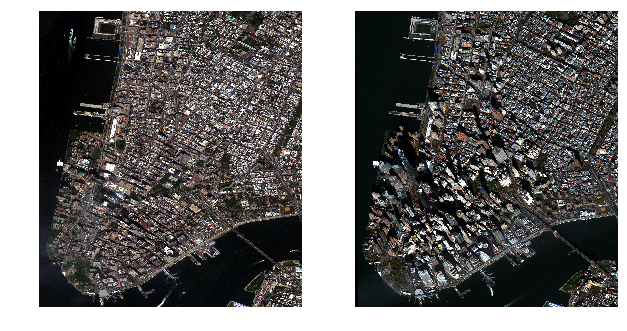

In [7]:
aoi1 = image1.aoi(bbox=[-74.02008533477785, 40.699641625343126, -73.99184631347658, 40.73145106322093])

aoi2 = image2[shape(aoi1)]

# Show both AOIs
plt.figure(figsize=(16,8))
plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(aoi1.rgb())

plt.subplot(1, 3, 2)
plt.axis('off')
plt.imshow(aoi2.rgb())

plt.show()

### GeoJSON Features 

Since images in gbdxtools interface cleanly with Shapely features it may be useful to define AOIs from geojson features. We can fetch geojson, convert features into shapely geometries and use those to index/extract AOIs from images. 

Below is an experiment that fetches a set of district polygons for New York City, finds one for Manhattan and subsets an image from that feature. 

59 features


Fetching Image... 150 tiles


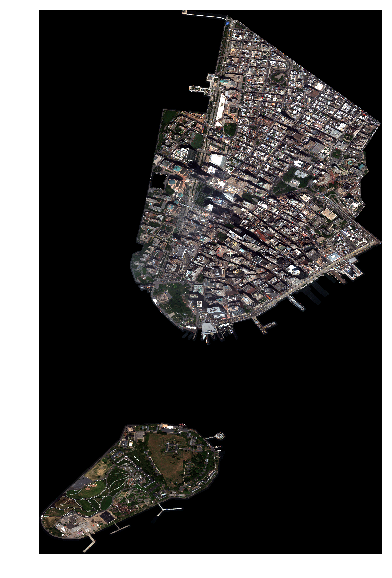

In [87]:
import requests
from rasterio.features import rasterize, geometry_mask
import matplotlib.pyplot as plt


geojson = requests.get('https://opendata.arcgis.com/datasets/01582b48646f415e993fbb39882bc0f3_0.geojson').json()
print len(geojson['features']), 'features'

for f in geojson['features']:
    if f['properties']['DISTRICT'] == 'MN01':
        manhattan = shape(f['geometry']).buffer(0.0001)

maoi = image1[manhattan]
mask = geometry_mask([maoi.__geo_interface__], out_shape=maoi[0,:,:].shape, transform=maoi.__geo_transform__._affine)
mask = np.broadcast_to(mask, (3,) + mask.shape)

rgb = maoi.rgb()
rgb[np.rollaxis(mask, 0, 3)] = 0 

plt.figure(figsize=(16,10))
plt.axis('off')
plt.imshow(rgb)
plt.show()

### Large AOIs

Sometimes its necessary to process either entire images or large AOIs. A large AOI would be considered any image with thousands of tiles. Plotting or even accessing such images can be tricky and time consuming. However, it's still an important pattern of analysis to understand. 

In this example we'll leverage Dask

Image classes in gbdxtools leverage Dask behind the scenes, and in this example we'll show how we can leverage Dasks `map_blocks` method to call a function that render and Dask has several nice methods that can help up process imagery. Since tiles on the server are stored as 256x256 arrays its important to first `rechunk` the image object into 256x256 (this can chunk size that you want)

In [65]:
import numpy as np

# rechunk the image to a desired input size
input_shape = (8, 256, 256)
prepared = manhattan_aoi.rechunk(input_shape)

# A method that receives each chunk as a 8x256x256 numpy array
def process(chunk):
    return chunk[[4,2,1],:,:]
   
# this results in a dask array that delays the computation until `compute` is called
result = prepared.map_blocks(process, dtype=np.float32)

In the example above we've built a new Dask array that has mapped the chunks of the image through a simple method, but we still haven't performed any. We have created a new Dask that delayed the computation until we call `compute`, a method that executes the Dask graph, which in our case fetches data and performs any computation needed to fulfill the graph. By just calling `compute()` directly, dask will execute in a single thread. By passing a `threaded_get` paramater to the compute we can speed up and parallelize our execution across many threads. 

In [ ]:
# Single Threaded 
r = result.compute()

In [62]:
# Multi-threaded 
from functools import partial
import dask
threaded_get = partial(dask.threaded.get, num_workers=8)

r = result.compute(get=threaded_get)

In [66]:
print r.shape

(3, 2213, 2139)
